In [19]:
# Test histogram balance
from pathlib import Path
import imageio
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import tz
import pandas as pd

from skimage import io
from skimage import data
from skimage import exposure
from skimage.exposure import match_histograms

from coastcam_funcs import *
from calibration_crs import *
from rectifier_crs import *
from rectify_caco_func import *

['1576598401.jpg', '1594314001.jpg', '1592056801.jpg', '1595527201.jpg', '1589738401.jpg', '1590933601.jpg', '1592319601.jpg', '1584381601.jpg', '1592157601.jpg', '1586977201.jpg']
1576598401.c2.timex.jpg


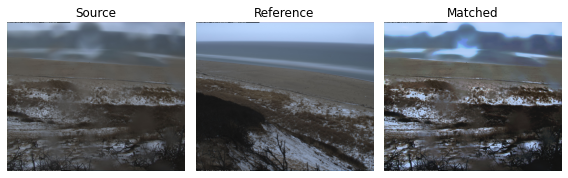

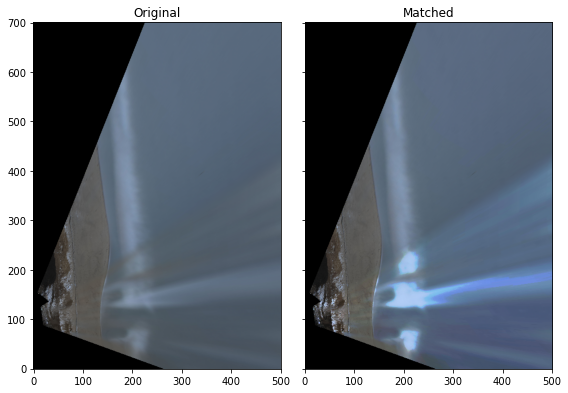

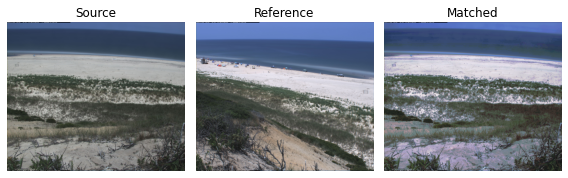

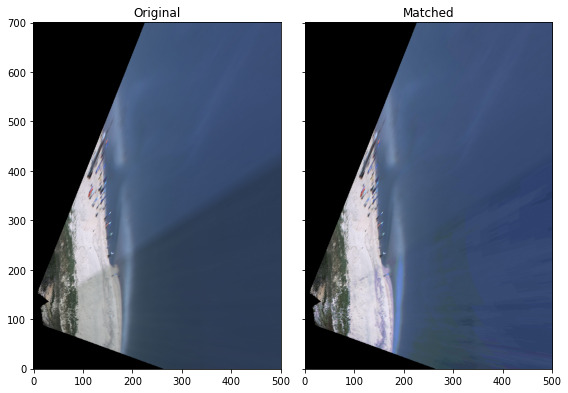

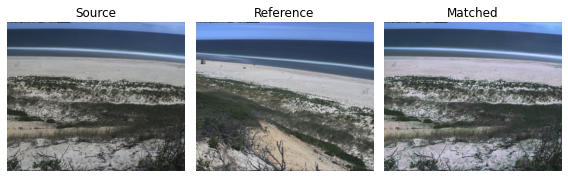

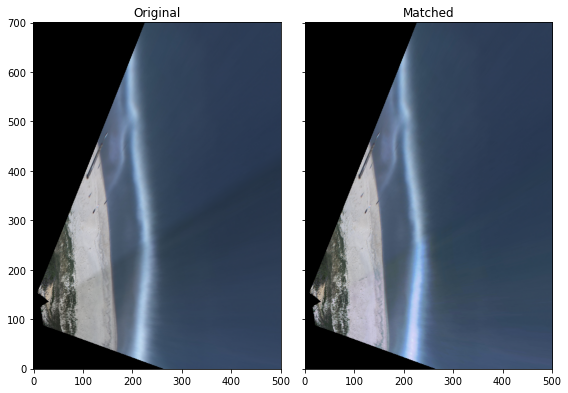

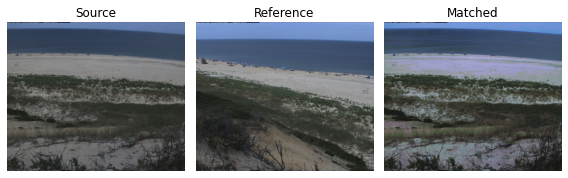

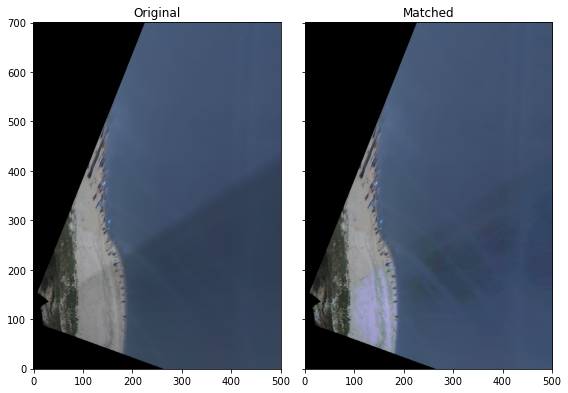

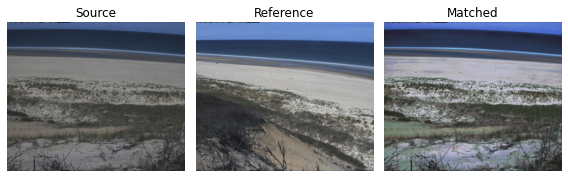

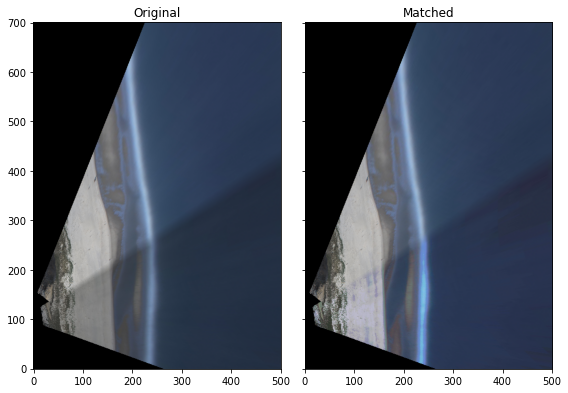

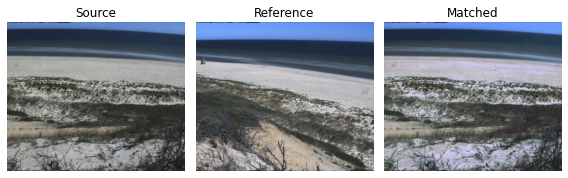

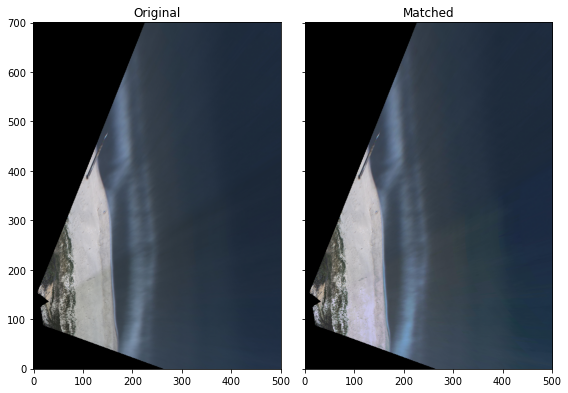

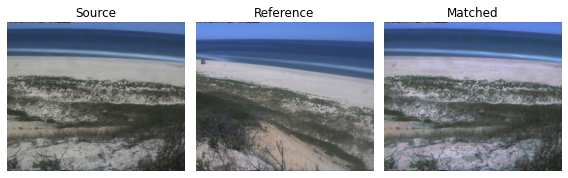

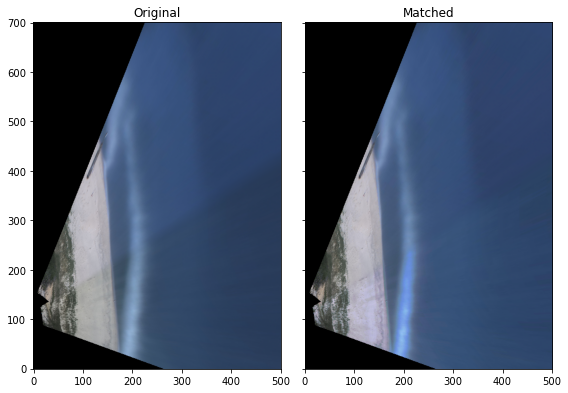

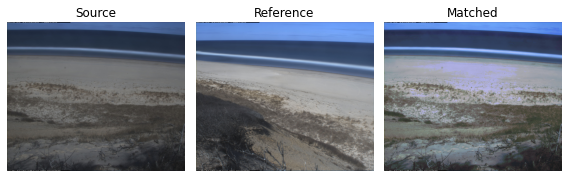

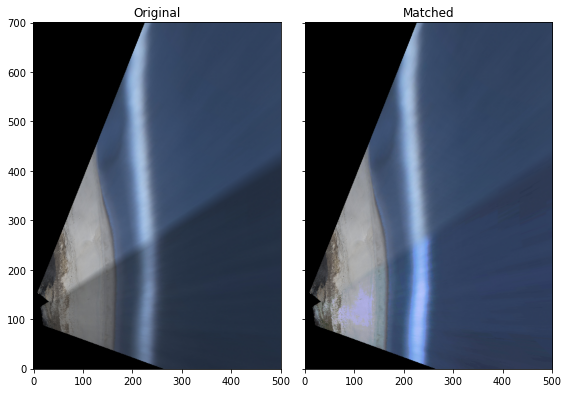

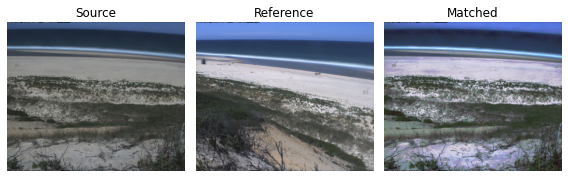

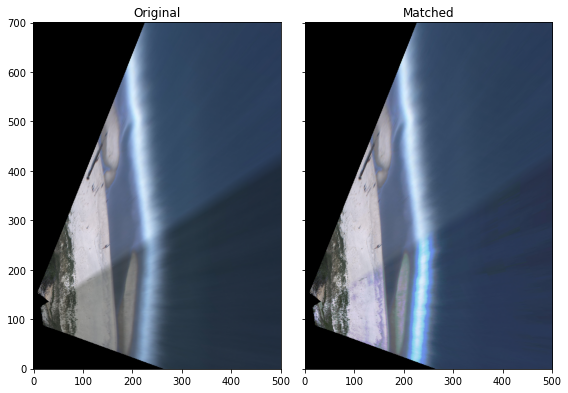

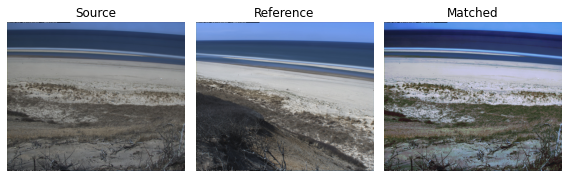

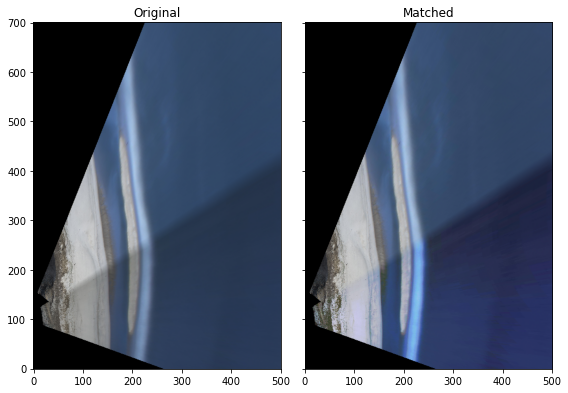

In [34]:
df10=pd.read_pickle('tenfiles.pkl')
flist=df10['filname'].to_list()
print(flist)

print(fn1)

# Read the files
# setup S3 buckets
imdir='cmgp-coastcam/cameras/caco-01/products/'
fs = fsspec.filesystem('s3',profile='coastcam')
#files = ['1576260001.c1.timex.jpg','1576260001.c2.timex.jpg']

for i, _ in enumerate(flist):

    fn0 = flist[i].split('.')[0]+'.c1.timex.jpg'
    fn1 = flist[i].split('.')[0]+'.c2.timex.jpg'

    files = [fn0,fn1]

    with fs.open(imdir+files[0],'rb') as f:
        imref = io.imread(f)

    with fs.open(imdir+files[1],'rb') as f:
        imsrc = io.imread(f)

    matched = match_histograms(imsrc, imref, multichannel=True)
    # save the images (because the rectification routine uses files, not image arrays)
    with open('c1ref.jpg', 'wb') as f1:
            imageio.imwrite(f1,imref,format='jpg')
    with open('c2matched.jpg', 'wb') as f2:
            imageio.imwrite(f2,matched,format='jpg')

    # rectify the images
    rimmatch = rectify_caco_func(['c1ref.jpg', 'c2matched.jpg'],fs=None)
    rim = rectify_caco_func([imdir+files[0], imdir+files[1]],fs=fs)

    # make a plot
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                        sharex=True, sharey=True)
    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()
    ax1.imshow(imsrc)
    ax1.set_title('Source')
    ax2.imshow(imref)
    ax2.set_title('Reference')
    ax3.imshow(matched)
    ax3.set_title('Matched')
    plt.tight_layout()
    plt.show()

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 6),
                                        sharex=True, sharey=True)
    ax1.imshow( rim.astype(np.int))
    ax1.invert_yaxis()
    ax1.set_title('Original')
    ax2.imshow( rimmatch.astype(np.int))
    ax2.invert_yaxis()
    ax2.set_title('Matched')
    plt.tight_layout()
    plt.show()